<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Для компании службы такси, чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

импортируем все необходимые библиотеки для работы.

In [1]:
# Обновим библиотеку statsmodels
!pip install -U statsmodels -q

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

Прочитаем файл, взглянем на него.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=True)
data.sort_index(inplace=True)
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проведем ресемплирование по одному часу. Построим график среднего количества заказов.

In [3]:
data = data.resample('1H').sum()
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Построим график суммарного количества заказов такси.

<AxesSubplot:xlabel='datetime'>

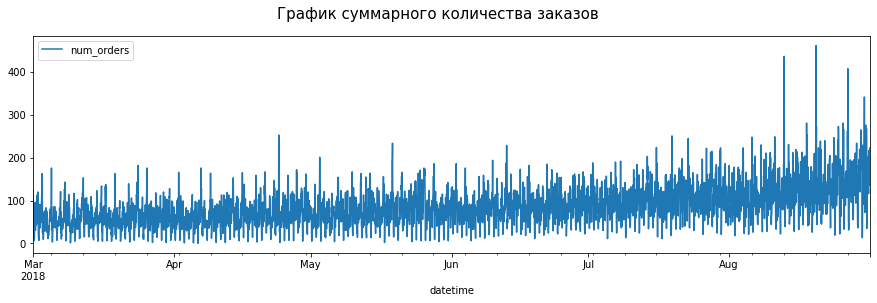

In [4]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('График суммарного количества заказов', fontsize = 15)
data.plot(ax=ax)

Видим, что график стабилен, виден рост после августа.

Так как в ряду много колебаний и график похож на кардиограмму, найдем скользящее среднее, построим график.

<AxesSubplot:xlabel='datetime'>

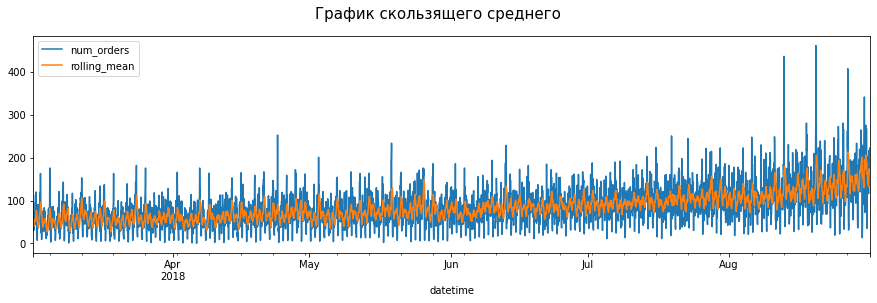

In [5]:
data['rolling_mean'] = data.rolling(10).mean()
data = data.dropna()

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('График скользящего среднего', fontsize = 15)
data.plot(ax=ax)

По скользыщему среднему видно, что март, апрель - количество заказов постоянно, после начинает расти. Это может быть связано с сезонностью. Проверим.

In [6]:
data.isna().sum()
data.head(11)

,num_orders,rolling_mean
datetime,,
2018-03-01 09:00:00,69,52.5
2018-03-01 10:00:00,64,46.5
2018-03-01 11:00:00,96,47.6
2018-03-01 12:00:00,30,43.5
2018-03-01 13:00:00,32,40.1
2018-03-01 14:00:00,48,40.6
2018-03-01 15:00:00,66,46.6
2018-03-01 16:00:00,43,49.7
2018-03-01 17:00:00,44,52.6


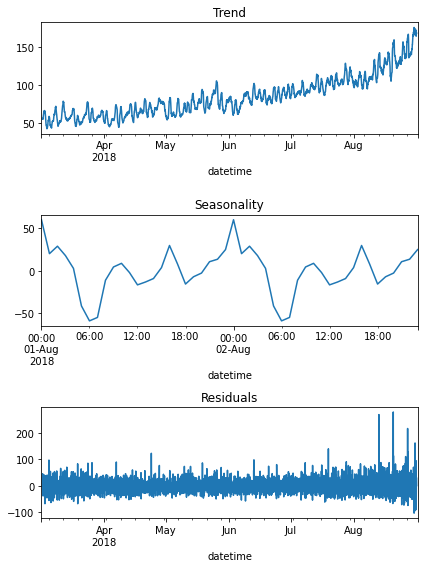

In [7]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Тренд четко прослеживается - заказы растут с апреля и далее до конца августа, покуда имеются данные. Видим сезонность - 06:00 заказов очень мало, в течении дня их количество растет и достигает своего пика в 00:00. Также встречаются пики в течении дня: около 10:00 и 16:00.

Проверим ряд на стационарность.

<AxesSubplot:xlabel='datetime'>

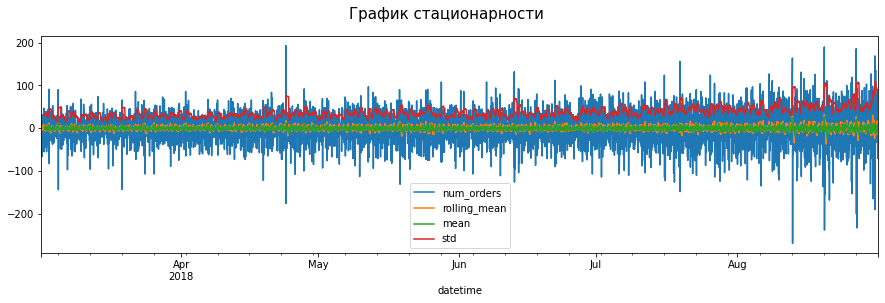

In [8]:
data_mean_std = data - data.shift()

data_mean_std['mean'] = data_mean_std['num_orders'].rolling(15).mean()
data_mean_std['std'] = data_mean_std['num_orders'].rolling(15).std()
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('График стационарности', fontsize = 15)
data_mean_std.plot(ax=ax)

По графику видно, что ряд стационарный и его можно прогнозировать.

## Обучение

Объявим функцию, которая будет возвращать датасет с созданными признаками: годом, месяцем, днем, днем недели, смещением и скользящим средним.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Применим для наших данных.

In [10]:
make_features(data, 30, 4)
display(data.head())

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 09:00:00,69,NaN,2018,3,1,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 10:00:00,64,NaN,2018,3,1,3,69.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 11:00:00,96,NaN,2018,3,1,3,64.0,69.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 12:00:00,30,NaN,2018,3,1,3,96.0,64.0,69.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 13:00:00,32,64.75,2018,3,1,3,30.0,96.0,64.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выделим трейновую и тестовую выборки. Проверим, что тест следует за трейном.

In [11]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
display (train.index.min(), train.index.max())
display (test.index.min(), test.index.max())

Timestamp('2018-03-02 15:00:00', freq='H')

Timestamp('2018-08-13 14:00:00', freq='H')

Timestamp('2018-08-13 15:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

Выделим признаки обучения и целевой признак. Обучим линейную регрессию.

In [12]:
features_train = train.drop(columns='num_orders')
target_train = train['num_orders']
features_test = test.drop(columns='num_orders')
target_test = test['num_orders']

model = LinearRegression().fit(features_train, target_train)
predict_train = model.predict(features_train)

display(f"RMSE обучающей выборки: {mean_squared_error(target_train, predict_train, squared=False):.3f}")

'RMSE обучающей выборки: 25.281'

In [13]:
tscv = TimeSeriesSplit(n_splits=3)
model_tree = DecisionTreeRegressor() 
max_depth = [i for i in range(2, 20)]
params = [{'criterion':['mse'], 
                'max_depth':max_depth, 
                'random_state':[12345]}]

grid_tree = GridSearchCV(model_tree, params, scoring='neg_mean_squared_error', cv=tscv)
grid_tree.fit(features_train, target_train)
display("Лучшие параметры для модели:")
display(grid_tree.best_params_)
means = grid_tree.cv_results_['mean_test_score']
stds = grid_tree.cv_results_['std_test_score']
cross_valid_tree = (max(means)*-1) ** 0.5
display(f'RMSE DecisionTreeRegressor cross valid = {cross_valid_tree:.3f}')

'Лучшие параметры для модели:'

{'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}

'RMSE DecisionTreeRegressor cross valid = 31.568'

In [14]:
model_tree = DecisionTreeRegressor(
    criterion='mse', 
    max_depth=3, 
    random_state=12345).fit(features_train, target_train)
pred_tree = model_tree.predict(features_train)
rmse_tree = (mean_squared_error(target_train, pred_tree))**0.5
display(f'RMSE DecisionTreeRegressor = {rmse_tree:.3f}')

'RMSE DecisionTreeRegressor = 27.853'

RMSE ниже порогового. Проверим на тестовой выборке.

## Тестирование

In [15]:
pred_linear = model.predict(features_test)
display(f"RMSE тестовой выборки: {mean_squared_error(target_test, pred_linear, squared=False):.3f}")

'RMSE тестовой выборки: 46.944'

In [16]:
pred_tree = model_tree.predict(features_test)
display(f"RMSE тестовой выборки: {mean_squared_error(target_test, pred_tree, squared=False):.3f}")

'RMSE тестовой выборки: 56.513'

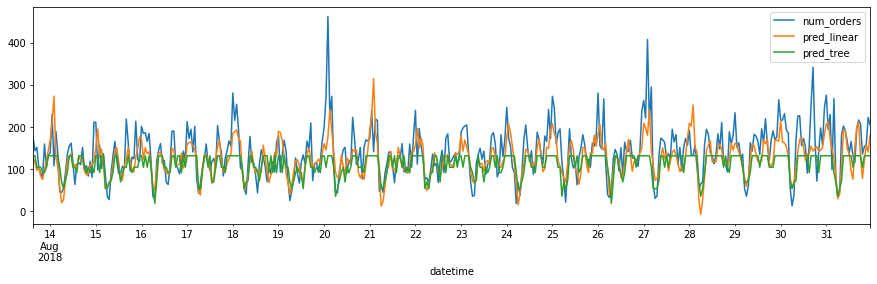

In [17]:
data_plot = target_test.reset_index()
pred_linear = pd.Series(data=pred_linear)
pred_tree = pd.Series(data=pred_tree)
data_plot['pred_linear'] = pred_linear
data_plot['pred_tree'] = pred_tree
data_plot = data_plot.set_index(keys='datetime')

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('', fontsize = 15)
data_plot.plot(ax=ax)
plt.show()

**Вывод**

После всех наших преобразований получаем уровень ошибки ниже порогового - следовательно наша модель на основе линейной регрессии предсказывает на достойном уровне. Модель на основе дерева решений не проходит пороговое значение RMSE.